In [1]:
import gymnasium as gym
import pandas as pd
import numpy as np
import pandas_ta as ta
import torch
import gym_trading_env
import datetime
import matplotlib
import matplotlib.pyplot as plt
from gym_trading_env.downloader import download
from time import time

from stable_baselines3 import A2C, PPO, DQN # only available for this RL Algorithm

In [2]:
# Constants
DIR = "../../data"
SYMBOL = "SUI/USDT" # you can change to any other symbol
TIMEFRAME = "5m" # 5m 15m 1h 4h 1d 1w 1M
EXCHANGE = "binance" # bitget binance bitfinex bitmex bitstamp coinbasepro huobi kraken kucoin okex
DISCORD_WEBHOOK_URL = "https://discord.com/api/webhooks/963662949489197147/ZedW9QI5N8kt5G-RCmniOlv4qOaYCduCbEJXMGi9YBxR6e-G0uSLaAg6BZLZ_G1fps36"
POSITIONS = [-1,-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8,1]
CPU_TRAINING_TIMES = 5
GPU_TRAINING_TIMES = 25

In [3]:
# Download BTC/USDT historical data from Binance and stores it to directory ./data/binance-BTCUSDT-1h.pkl
download(exchange_names = [EXCHANGE],
    symbols= [SYMBOL],
    timeframe= TIMEFRAME,
    dir = DIR,
    since= datetime.datetime(year= 2023, month= 11, day= 1),
)
# Import your fresh data
df:pd.DataFrame = pd.read_pickle(DIR+"/"+EXCHANGE+"-"+SYMBOL.replace("/","")+"-"+TIMEFRAME+".pkl")

SUI/USDT downloaded from binance and stored at ../../data/binance-SUIUSDT-5m.pkl


In [4]:
# Handle more feature
df['feature_open'] = df['open'] #1
df['feature_high'] = df['high'] #2
df['feature_low'] = df['low']  #3
df['feature_close'] = df['close'] #4
df['feature_volume'] = df['volume'] #5
df['feature_close_pct_change'] = df['close'].pct_change() #6
df['feature_volume_pct_change'] = df['volume'].pct_change() #7
df['feature_shift_1_close'] = df['close'].shift(1) #8
df['feature_shift_1_open'] = df['open'].shift(1) #9
df['feature_shift_1_volume'] = df['volume'].shift(1) #10
df['feature_shift_2_close'] = df['close'].shift(2) #11
df['feature_shift_2_open'] = df['open'].shift(2) #12
df['feature_shift_2_volume'] = df['volume'].shift(2) #13
df['feature_shift_3_close'] = df['close'].shift(3) #14
df['feature_shift_3_open'] = df['open'].shift(3) #15
df['feature_shift_3_volume'] = df['volume'].shift(3) #16
df['feature_shift_4_close'] = df['close'].shift(4) #17
df['feature_shift_4_open'] = df['open'].shift(4) #18
df['feature_shift_4_volume'] = df['volume'].shift(4) #19
df['feature_shift_5_close'] = df['close'].shift(5) #20
df['feature_shift_5_open'] = df['open'].shift(5) #21
df['feature_shift_5_volume'] = df['volume'].shift(5) #22
df['feature_LONGLINE'] = df.ta.cdl_pattern(name="longline")['CDL_LONGLINE'] #23
df['feature_HIKKAKE'] = df.ta.cdl_pattern(name="hikkake")['CDL_HIKKAKE'] #24
df['feature_HARAMICROSS'] = df.ta.cdl_pattern(name="haramicross")['CDL_HARAMICROSS'] #25
temp = df.ta.macd() 
df['feature_MACD'] = temp['MACD_12_26_9'] #26
df['feature_MACD_SIGNAL'] = temp['MACDs_12_26_9'] #27
df['feature_MACD_HIST'] = temp['MACDh_12_26_9'] #28
df['feature_RSI'] = df.ta.rsi() #29
df['feature_VWAP'] = df.ta.vwap() #30
df['feature_MASSI'] = df.ta.massi() #31
df['feature_ATR'] = df.ta.atr() #32
df['feature_CKSPL'] = df.ta.cksp()['CKSPl_10_3_20'] #33
df['feature_CKSPS'] = df.ta.cksp()['CKSPs_10_3_20'] #34
df['feature_ADX'] = df.ta.adx()['ADX_14'] #35
df = df.drop(columns=['date_close'])
df = df.dropna()

In [5]:
def reward_func(history):
    # history is a list of actions
    # return a reward value
    last_reward = history['reward', -1] # change + reward
    reward_score = np.log(history["portfolio_valuation", -1] / history["portfolio_valuation", -2]) 
    if reward_score > 0:reward_score += reward_score * 0.5
    else:reward_score -= reward_score * 0.1
    return reward_score + last_reward

In [6]:
train_df = df.iloc[:int(len(df)*0.99)]
test_df = df.iloc[int(len(df)*0.99):]

In [7]:
# need to switch to custom env
env = gym.make("TradingEnv", df = train_df, positions = [-1,-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8,1], initial_position= 0, trading_fees = 0.02/100, reward_function = reward_func,verbose=1)

env.unwrapped.add_metric('Position Changes', lambda history : np.sum(np.diff(history['position']) != 0) )
env.unwrapped.add_metric('Episode Lenght', lambda history : len(history['position']) )
env.unwrapped.add_metric('Win Rate', lambda history : np.sum(history['reward'] > 0) / len(history['reward']) )

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

In [8]:
from stable_baselines3.common.callbacks import BaseCallback

history = {
    "portfolio_return": [],
    "win rate": [],
    "position changes": [],
}

class CustomCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(CustomCallback, self).__init__(verbose)

    def _on_step(self) -> bool:
        if 'done' in self.locals and self.locals['done']:
            history['portfolio_return'].append(float(env.unwrapped.get_metrics()['Portfolio Return'].replace("%","")))
            history['win rate'].append(env.unwrapped.get_metrics()['Win Rate'])
            history['position changes'].append(env.unwrapped.get_metrics()['Position Changes'])
        return True


In [9]:
train_df.shape

(7623, 40)

In [10]:
model = A2C('MlpPolicy', env, verbose=0)

In [11]:
if str(model.device) == "cpu":
    training_times = CPU_TRAINING_TIMES
else:
    training_times = GPU_TRAINING_TIMES

print("Training on", model.device, "for", training_times, "times")

Training on cpu for 5 times


In [12]:
time_start = time()
model.learn(total_timesteps=train_df.shape[0]*training_times, callback=CustomCallback())
time_end = time()

Market Return : 38.44%   |   Portfolio Return : -65.59%   |   Position Changes : 6808   |   Episode Lenght : 7623   |   Win Rate : 0.4342122523940706   |   
Market Return : 38.44%   |   Portfolio Return : -57.85%   |   Position Changes : 6067   |   Episode Lenght : 7623   |   Win Rate : 0.4462809917355372   |   
Market Return : 38.44%   |   Portfolio Return : -0.41%   |   Position Changes : 2009   |   Episode Lenght : 7623   |   Win Rate : 0.48235602781057324   |   
Market Return : 38.44%   |   Portfolio Return : 32.36%   |   Position Changes : 931   |   Episode Lenght : 7623   |   Win Rate : 0.48563557654466744   |   
Market Return : 38.44%   |   Portfolio Return : 40.12%   |   Position Changes : 33   |   Episode Lenght : 7623   |   Win Rate : 0.489833398924308   |   


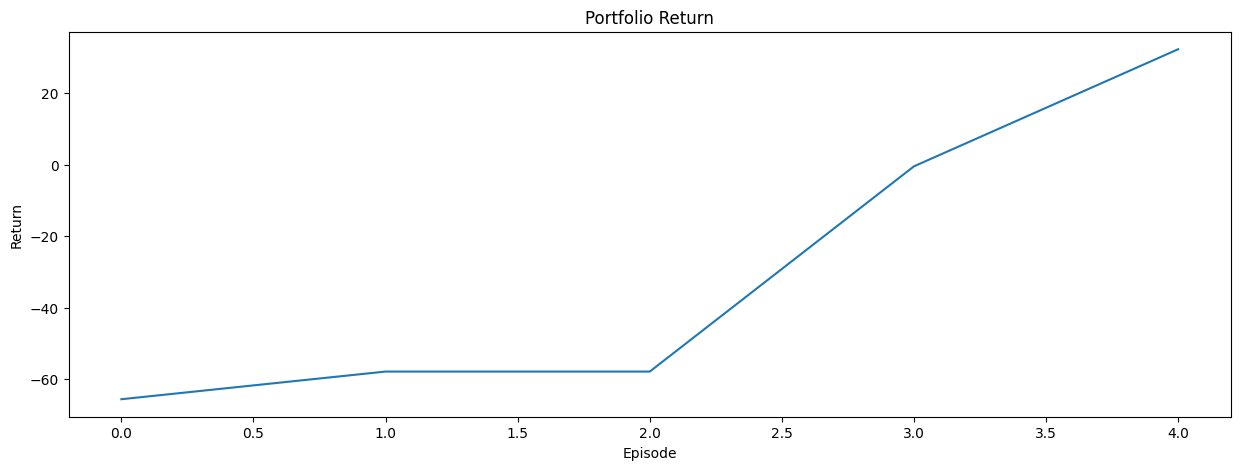

In [13]:
# Plotting
plt.figure(figsize=(15,5))
plt.plot(history['portfolio_return'])
plt.title('Portfolio Return')
plt.xlabel('Episode')
plt.ylabel('Return')
plt.savefig('portfolio_return.png')
plt.show()

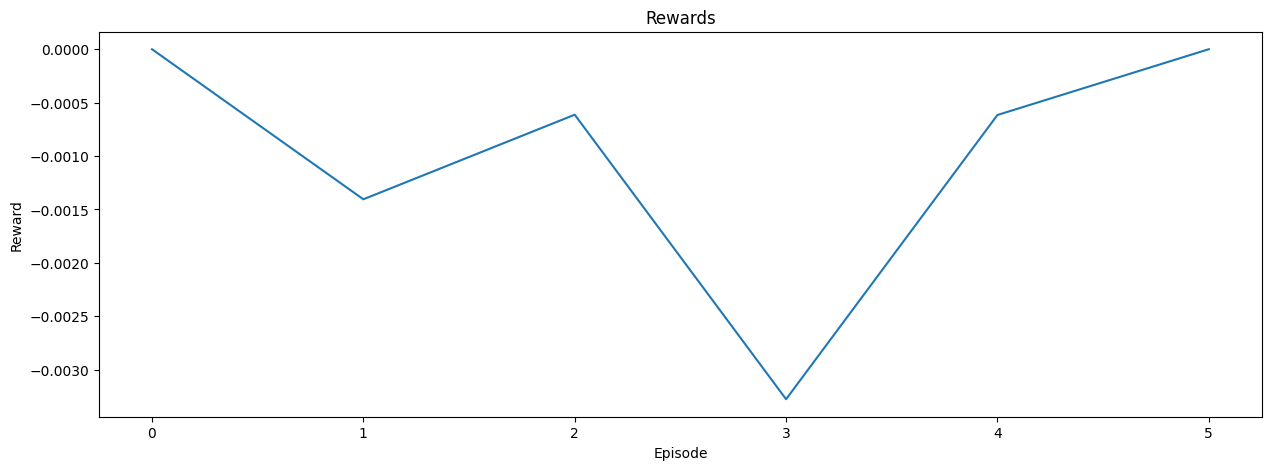

In [14]:
history_rewards = env.unwrapped.historical_info['reward']
plt.figure(figsize=(15,5))
plt.plot(history_rewards)
plt.title('Rewards')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

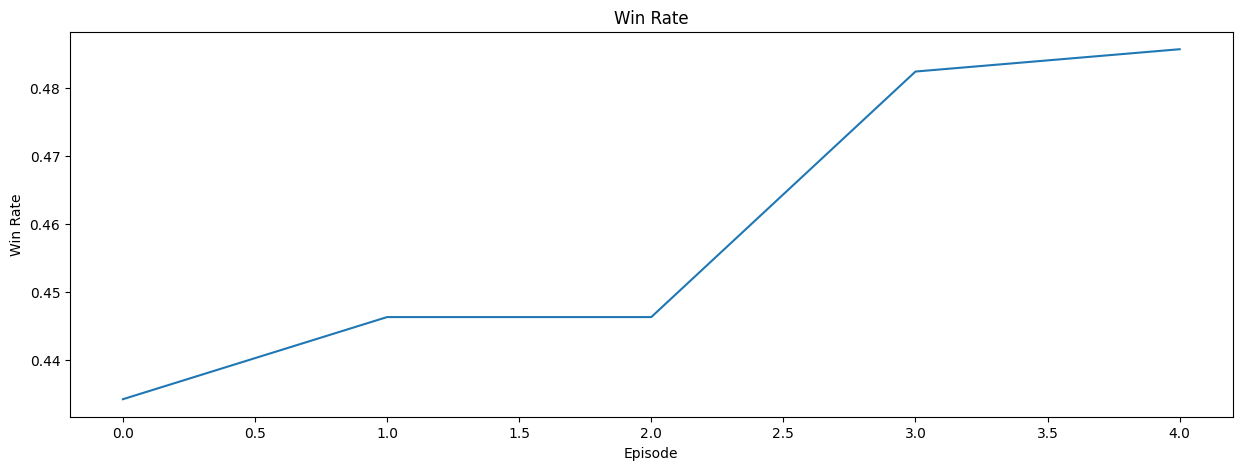

In [15]:
plt.figure(figsize=(15,5))
plt.plot(history['win rate'])
plt.title('Win Rate')
plt.xlabel('Episode')
plt.ylabel('Win Rate')
plt.show()

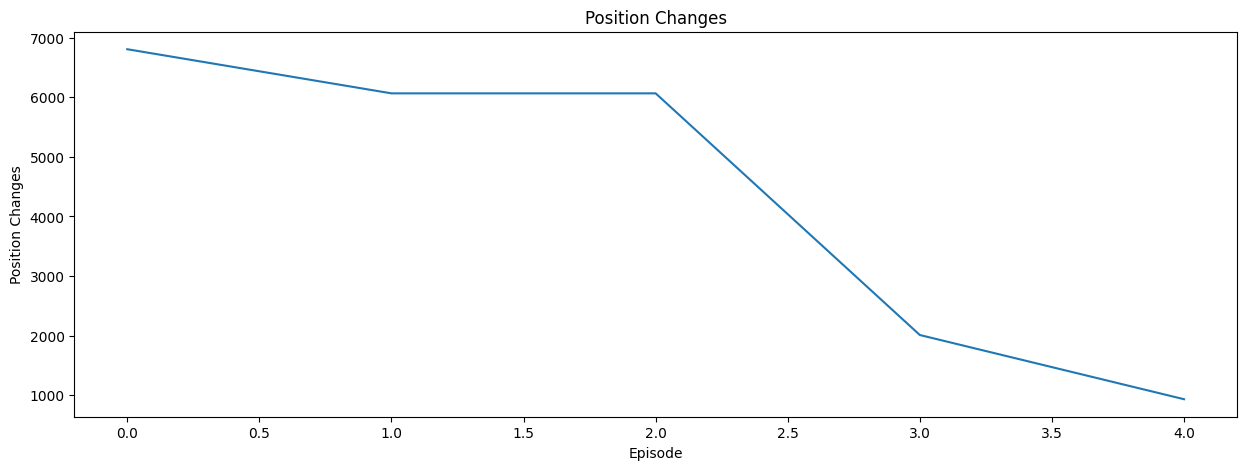

In [16]:
plt.figure(figsize=(15,5))
plt.plot(history['position changes'])
plt.title('Position Changes')
plt.xlabel('Episode')
plt.ylabel('Position Changes')
plt.show()

In [17]:
test_env = gym.make("TradingEnv", df = test_df, positions = [-1,-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8,1], initial_position= 0, trading_fees = 0.02/100, reward_function = reward_func,verbose=1)

state, info = test_env.reset() #portfolio_valuation
done = False
terminated = False
while not done and not terminated:
    action, _info = model.predict(state)
    state, reward, done, terminated, info = test_env.step(action)
    test_env.render()

Market Return : -2.31%   |   Portfolio Return : -2.33%   |   


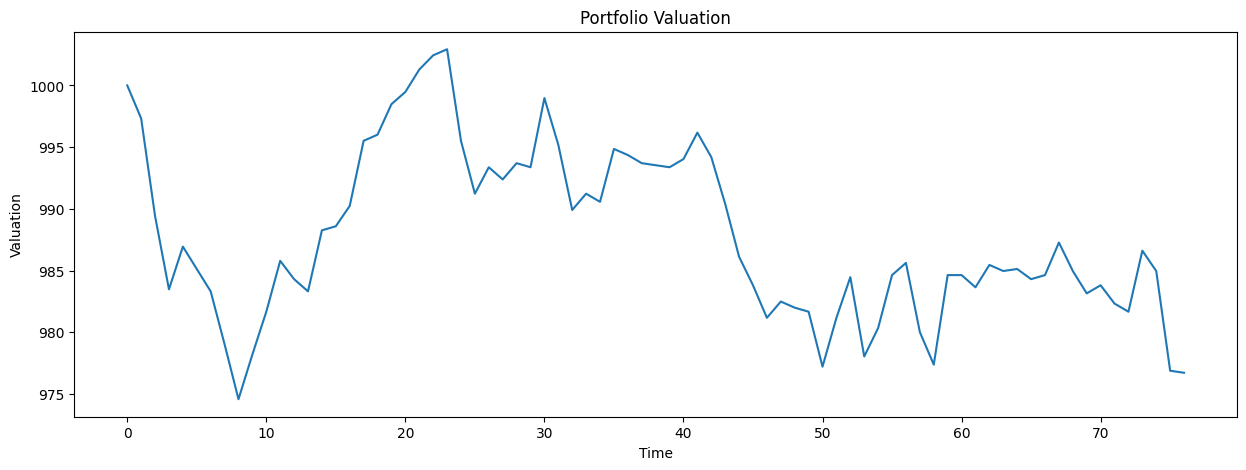

In [18]:
#plotting
plt.figure(figsize=(15,5))
plt.plot(test_env.unwrapped.historical_info['portfolio_valuation'])
plt.title('Portfolio Valuation')
plt.xlabel('Time')
plt.ylabel('Valuation')
plt.savefig('portfolio_valuation.png')
plt.show()

In [19]:
template = """
====================
|  AI Trading Bot  |
====================
Training Complete
====================

Trading Symbol: {symbol}
Timeframe: {timeframe}
Exchange: {exchange}
Training Time: {time} minutes
"""


if DISCORD_WEBHOOK_URL:
    import requests

    # Text result

    mertics_metadata:dict = env.unwrapped.get_metrics()
    mertics_data = [f"{key}: {value}" for key, value in mertics_metadata.items()]

    template += "\n".join(mertics_data)

    data = {
        "content": template.format(
            time = (time_end - time_start) / 60,
            symbol = SYMBOL,
            timeframe = TIMEFRAME,
            exchange = EXCHANGE
        ),
        "username": "AI Trader Notification",
        "avatar_url": "https://i.imgur.com/4bY31Fb.jpg"
    }

    r = requests.post(DISCORD_WEBHOOK_URL, data=data)

    if r.status_code != 204:
        print(f"Discord Webhook returned status code {r.status_code}")
    else:
        print("Discord Webhook Sent")

Discord Webhook Sent


In [20]:
template = """
====================
Result Image (Portfolio Return)
====================
"""

if DISCORD_WEBHOOK_URL:
    # image result

    files = {
        "file": ("portfolio_return.png", open("portfolio_return.png", "rb")),
    }

    data = {
        "content": template,
        "username": "AI Trader Notification",
        "avatar_url": "https://i.imgur.com/4bY31Fb.jpg"
    }

    r = requests.post(DISCORD_WEBHOOK_URL, data=data, files=files)

    if r.status_code != 200:
        print(f"Discord Webhook returned status code {r.status_code}")
    else:
        print("Discord Webhook Sent")

Discord Webhook Sent


In [21]:
template = """
====================
Result Image (Portfolio Valuation)
====================
"""

if DISCORD_WEBHOOK_URL:
    # image result

    files = {
        "file": ("portfolio_valuation.png", open("portfolio_valuation.png", "rb")),
    }

    data = {
        "content": template,
        "username": "AI Trader Notification",
        "avatar_url": "https://i.imgur.com/4bY31Fb.jpg"
    }

    r = requests.post(DISCORD_WEBHOOK_URL, data=data, files=files)

    if r.status_code != 200:
        print(f"Discord Webhook returned status code {r.status_code}")
    else:
        print("Discord Webhook Sent")

Exception ignored in: <_io.FileIO name='portfolio_return.png' mode='rb' closefd=True>
Traceback (most recent call last):
  File "C:\Users\hiban\AppData\Local\Temp\ipykernel_20288\2853798784.py", line 10, in <module>


Discord Webhook Sent
